### Pre Requisities 

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float, ForeignKey,func, desc, extract
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

### Creating Connection to the database

In [2]:
engine = create_engine("sqlite:///hawaii.db", echo=False)
conn = engine.connect()

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['Measurements', 'Stations']

In [4]:
m = Base.classes.Measurements
s = Base.classes.Stations

In [5]:
session = Session(bind=engine)

### Precipitation Analysis

In [31]:
#prec_qry = session.query(m.date, m.prcp).filter(m.date>='2016-07-01').order_by(m.date)
prec_qry = session.query(m.date, m.prcp).filter(m.date>='2017-07-01').order_by(m.date)

In [32]:
print(prec_qry)

SELECT "Measurements".date AS "Measurements_date", "Measurements".prcp AS "Measurements_prcp" 
FROM "Measurements" 
WHERE "Measurements".date >= ? ORDER BY "Measurements".date


In [8]:
prec_df = pd.read_sql(prec_qry.statement, prec_qry.session.bind)

In [9]:
prec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
date    285 non-null object
prcp    285 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.5+ KB


In [10]:
prec_df.set_index('date', inplace=True)
prec_df.head()
prec_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 2017-07-01 to 2017-08-23
Data columns (total 1 columns):
prcp    285 non-null float64
dtypes: float64(1)
memory usage: 4.5+ KB


In [11]:
prec_df = prec_df.apply(pd.to_numeric)
prec_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 2017-07-01 to 2017-08-23
Data columns (total 1 columns):
prcp    285 non-null float64
dtypes: float64(1)
memory usage: 4.5+ KB


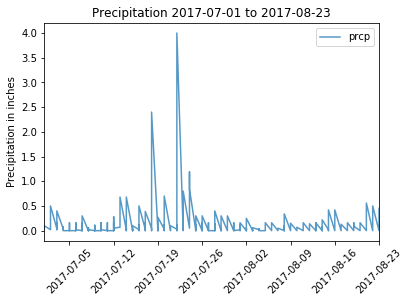

In [35]:
plt.figure(figsize=(18,4))
prec_df.plot(rot=45,alpha=0.75)
plt.ylabel('Precipitation in inches')
plt.xlabel("")
plt.title("Precipitation 2017-07-01 to 2017-08-23")
plt.show()

In [13]:
prec_df.describe()

,prcp
count,285.000000
mean,0.117186
std,0.312267
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,4.000000


### Station Analysis

In [14]:
stationCount = session.query(s.id).count()
stationCount

9

In [43]:
stationCounts = session.query(s.name,m.station,func.count(m.id).label('Station Counts')).filter(s.station==m.station).group_by(s.id,m.station).order_by(desc('Station Counts')).all()
stationCounts

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('PEARL CITY, HI US', 'USC00517948', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [38]:
Subquery = session.query(m.station.label('station'),func.count(m.id).label('Counts')).group_by(m.station).order_by(desc('Counts')).subquery()

In [17]:
max_observation = session.query(Subquery.c.station,func.max(Subquery.c.Counts)).scalar()
max_observation

'USC00519281'

In [18]:
max_date = session.query(m.date).order_by(m.date.desc()).first()
relativedelta(years=1)

relativedelta(years=+1)

In [19]:
last_year = max_date[0]- relativedelta(years=1)
last_year

datetime.date(2016, 8, 23)

In [20]:
tobs = session.query(m.date, m.tobs).filter(m.date>=last_year).filter(m.station==max_observation).order_by(m.date).all()

In [27]:
#tobs

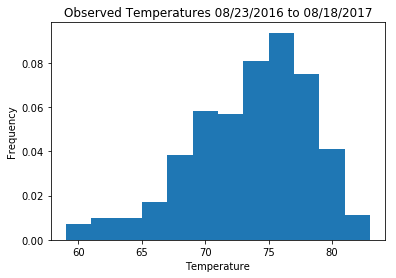

In [22]:
temps = [x[1] for x in tobs]
plt.hist(temps, normed=True, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Observed Temperatures 08/23/2016 to 08/18/2017")
plt.show()

### Temperature Analysis

In [40]:
def calc_temps(start_date, end_date):
    result = session.query(func.max(m.tobs).label('max_temp'), func.min(m.tobs).label('min_temp'), func.avg(m.tobs).label('avg_temp')).filter(m.date.between(start_date, end_date)).first()
    print("Temperature within trip duration - Max Temp:", result.max_temp, " Min Temp:", result.min_temp, " Avg Temp:", result.avg_temp)
    return result
   
t = calc_temps('2016-05-01','2016-05-14')
t

Temperature within trip duration - Max Temp: 79.0  Min Temp: 65.0  Avg Temp: 72.85227272727273


(79.0, 65.0, 72.85227272727273)

In [41]:
pre_year_temp = calc_temps('2015-10-01','2015-10-14')
pre_year_temp

Temperature within trip duration - Max Temp: 84.0  Min Temp: 66.0  Avg Temp: 75.83333333333333


(84.0, 66.0, 75.83333333333333)

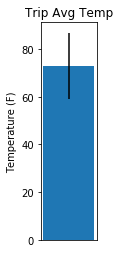

In [42]:
plt.figure(figsize=(1,4))
err=t.max_temp-t.min_temp
x_axis = 0
plt.bar(x_axis, t.avg_temp, yerr=err)
plt.xticks([0])
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
plt.show()

In [44]:
def daily_normals(dt_lst):
    temp_min, temp_max, temp_avg = [], [], []     
    for dt1 in dt_lst:
        dt1_str = '%-' + dt1[5:]
        temp = session.query(func.max(Measurement.tobs).label('max_temp'), func.min(Measurement.tobs).label('min_temp'), func.avg(Measurement.tobs).label('avg_temp')).filter(Measurement.date.like(dt1_str)).first()
        print("Estimated Temperatures for" , dt1, " - Max Temp:", temp.max_temp, " Min Temp:", temp.min_temp, " Avg Temp:", temp.avg_temp)  